# <span style='color:green; background-color:#dcffe4;'> **LSTM 구현** </span>

**LSTM구현에 필요한 수식**

$$ f = \sigma(x_tW_x^{(f)} + h_{t-1}W_h^{(f)}+b^{(f)})\\
g = tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})\\
i = \sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})\\
o = \sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})\\
affine\ transformation\ :\ x_tW_x^{(f)} + h_{t-1}W_h^{(f)}+b^{(f)}\\\ \\
c_t = f⊙c_{t-1} + g⊙i\\
h_t = o⊙tanh(c_t)
$$

In [3]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
class LSTM:
  # 초기화 인수는 매개변수 가중치 Wx Wh와 Bias b가 있다.
  def __init__(self, Wx, Wh, b):
    # 매개변수를 Parameter에 할당
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_likes(Wh), np.zeros_like(b)]
    # Front Prop의 결과를 저장하고 Back Prop 계산에 활용하기 위한 Cache
    self.cache = None
  
  # x : current input, h_prev : Previous hidden state, c_prev : cache of previous time
  # affine transformation : 행렬 변환과 편향을 결합 각각의 식 내부에 위치한 식을 의미함
  def forward(self, x, h, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    # formula g
    A = np.matmul(x, Wx) + mp.matmul(h_prev)

    # slice
    f = A[:,:H]
    g = A[:,H:2*H]
    i = A[:,2*H:3*H]
    o = A[:,3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    # c_next & h_next
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    # (Diff)h_t
    tanh_c_next = np.tanh(c_next)
    
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    
    # by Chain Rule
    dc_prev = ds * f

    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i

    # (Diff)Sigmoid(x) = sigmoid(x)(1 - sigmoid(x))
    # (Diff)tanh = (1−tanh(x))(1+tanh(x))
    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)

    # concat
    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev
 
  

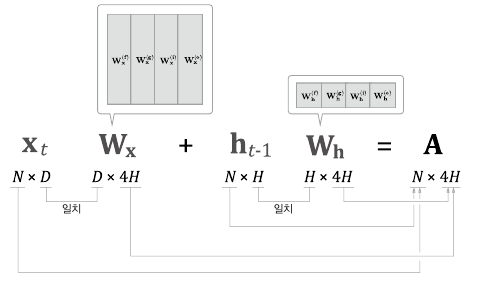


해당 Image에서는 mini Batch 수를 N, 입력 차원 수를 D, cache cell과 hidden state의 차원 수가 모두 H로 표시되어 있다. 계산 결과인 A에는 4개 분의 Affine Transformation결과가 저장된다. 이 결과에 의해 각각의 데이터가 A[:,:H], A[:,H:2H]와 같은 형태로 slicing된다. 이 데이터를 다음의 연산 node에 배분하게 된다.

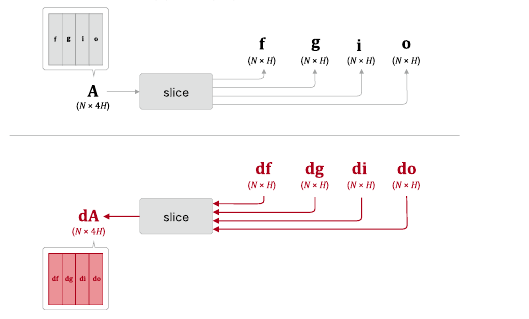

위에서 보듯 Slicing된 node의 Back Prop에서는 4개의 행렬을 연결한다. 그림에서는 4개의 기울기 df, dg, di, do를 연결해서 dA를 만든다. 이는 `numpy`에서 `numpy.hstack()`을 통해 간단하게 표현할 수 있다.

```python
dA = np.hstack((df, dg, di, do))
```

$$ {d \over dx} sigmoid(x)=sigmoid(x)(1-sigmoid(x))\\{d \over dx}tanh(x) = (1-tanh(x))(1+tanh(x))$$

In [5]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None